In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
#from lesson_functions import *
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

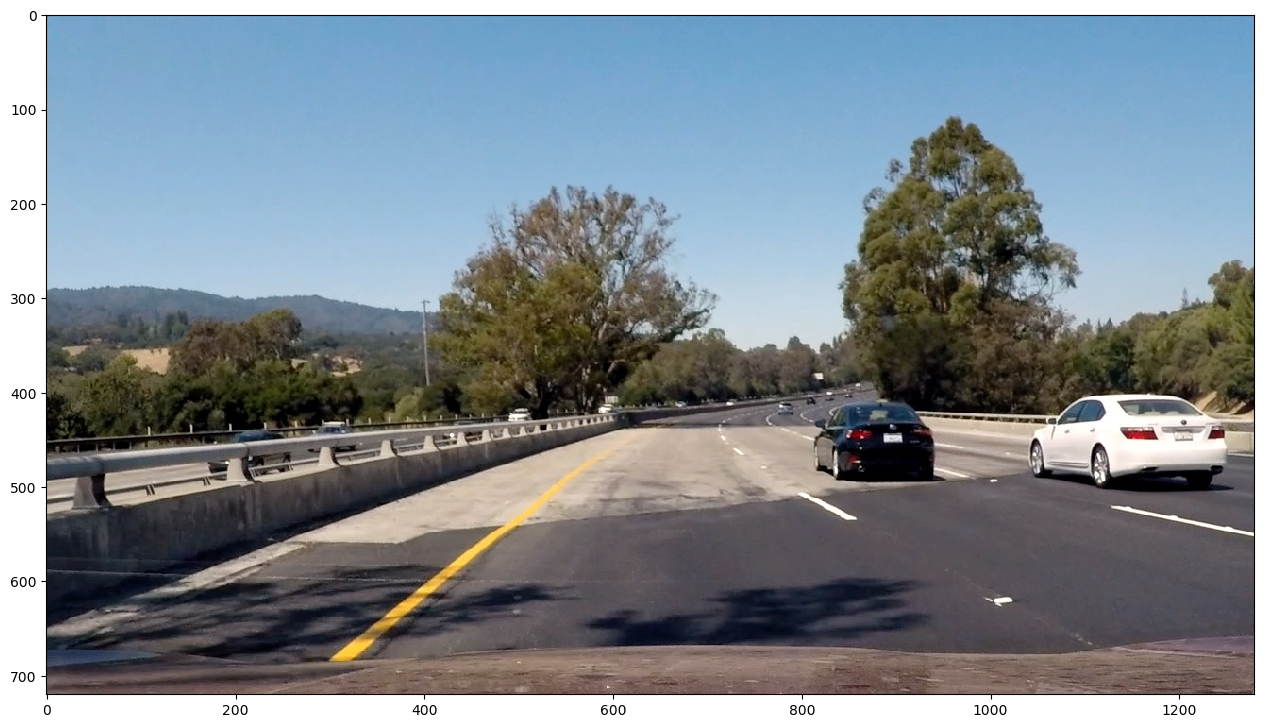

In [2]:
test_img = mpimg.imread('./test_images/test4.jpg')
plt.figure(figsize=(16,9), dpi=100)
plt.imshow(test_img)

# Generate grids
Here to tune the ammount of searching grids

In [3]:
from vehicle_detector import generate_grid
from draw_utils import draw_boxes

In [4]:
# Grid 0
#ystart_0 = 400-2*8
#ystop_0 = 400+1*64+2*8
#scale_0 = 0.8
#grid_0 = generate_grid(test_img, ystart_0, ystop_0, scale_0)

In [5]:
# Gird 1
ystart_1 = 400-2*8
ystop_1 = 400+2*64+2*8
scale_1 = 1.3
grid_1 = generate_grid(test_img, ystart_1, ystop_1, scale_1)

In [6]:
# Grid 2
ystart_2 = 400-2*8
ystop_2 = 656
scale_2 = 1.8
grid_2 = generate_grid(test_img, ystart_2, ystop_2, scale_2)

In [7]:
# Gird 3
ystart_3 = 400-32
ystop_3 = 656
scale_3 = 2.3
grid_3 = generate_grid(test_img, ystart_3, ystop_3, scale_3)

In [8]:
# draw
#grid_img = draw_boxes(test_img, grid_0)
grid_img = draw_boxes(test_img, grid_1)
grid_img = draw_boxes(grid_img, grid_2)
grid_img = draw_boxes(grid_img, grid_3)

In [9]:
len(grid_1+grid_2+grid_3)

45

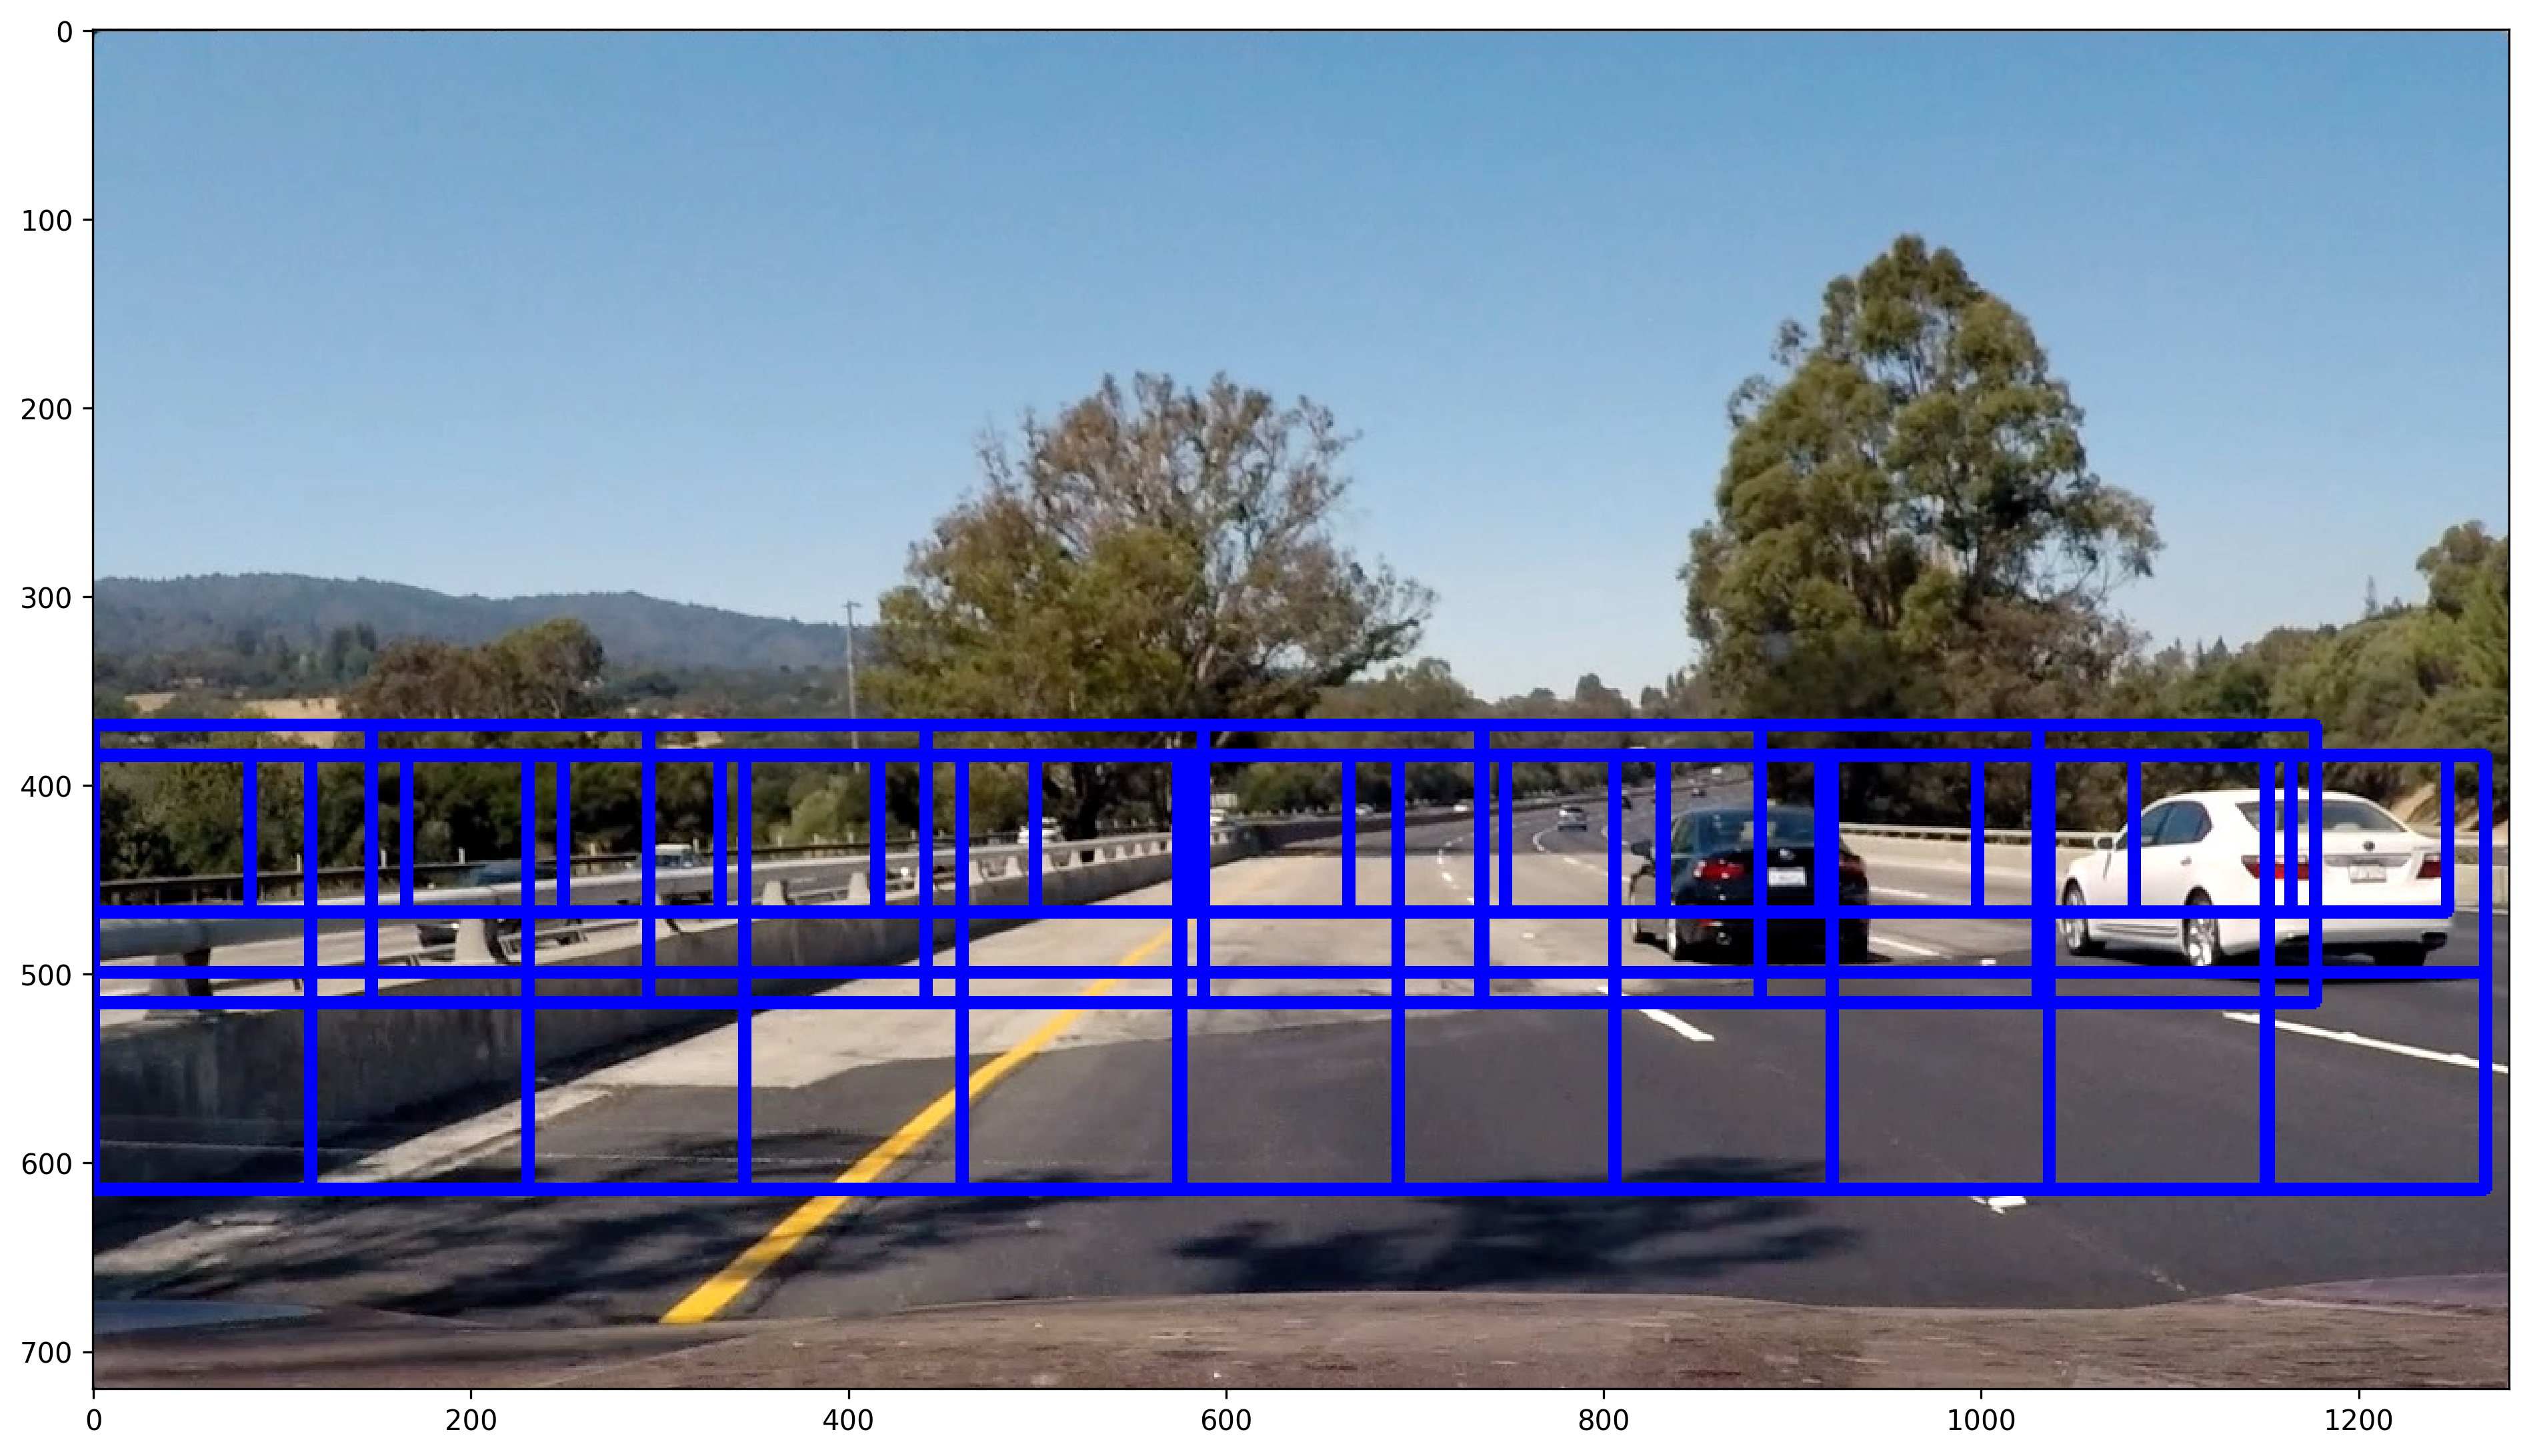

In [10]:
plt.figure(figsize=(16,9), dpi=300)
plt.imshow(grid_img)

# Detect vehicles in image

In [11]:
# First load the classifier
from vehicle_classifier import load_trained_model
classifier = load_trained_model('./trained_models/SVM_HLS.p')

The result from './trained_models/SVM_HLS.p' is totally not usable!

In [12]:
svc = classifier['classifier']
scaler = classifier['scaler']

config = {}
config['color_space']     = classifier['color_space']
config['spatial_size']    = classifier['spatial_size']
config['hist_bins']       = classifier['hist_bins']
config['orient']          = classifier['orient']
config['pix_per_cell']    = classifier['pix_per_cell']
config['cell_per_block']  = classifier['cell_per_block']
config['hog_channel']     = classifier['hog_channel']
config['spatial_feat']    = classifier['spatial_feat']
config['hist_feat']       = classifier['hist_feat']
config['hog_feat']        = classifier['hog_feat']

In [13]:
from vehicle_detector import find_cars

# Use the defined grids from the previous cells
def search_all_scales(image):
    
    #detected_boxes = find_cars(image, ystart_0, ystop_0, scale_0, svc, scaler, config)
    detected_boxes = find_cars(image, ystart_1, ystop_1, scale_1, svc, scaler, config)
    detected_boxes += find_cars(image, ystart_2, ystop_2, scale_2, svc, scaler, config)
    detected_boxes += find_cars(image, ystart_3, ystop_3, scale_3, svc, scaler, config)
    
    return detected_boxes

In [14]:
t_start = time.time()
detected_boxes = search_all_scales(test_img)
t_end = time.time()

print('Search time {}s'.format(round(t_end - t_start, 2)))

d:\anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Search time 0.69s


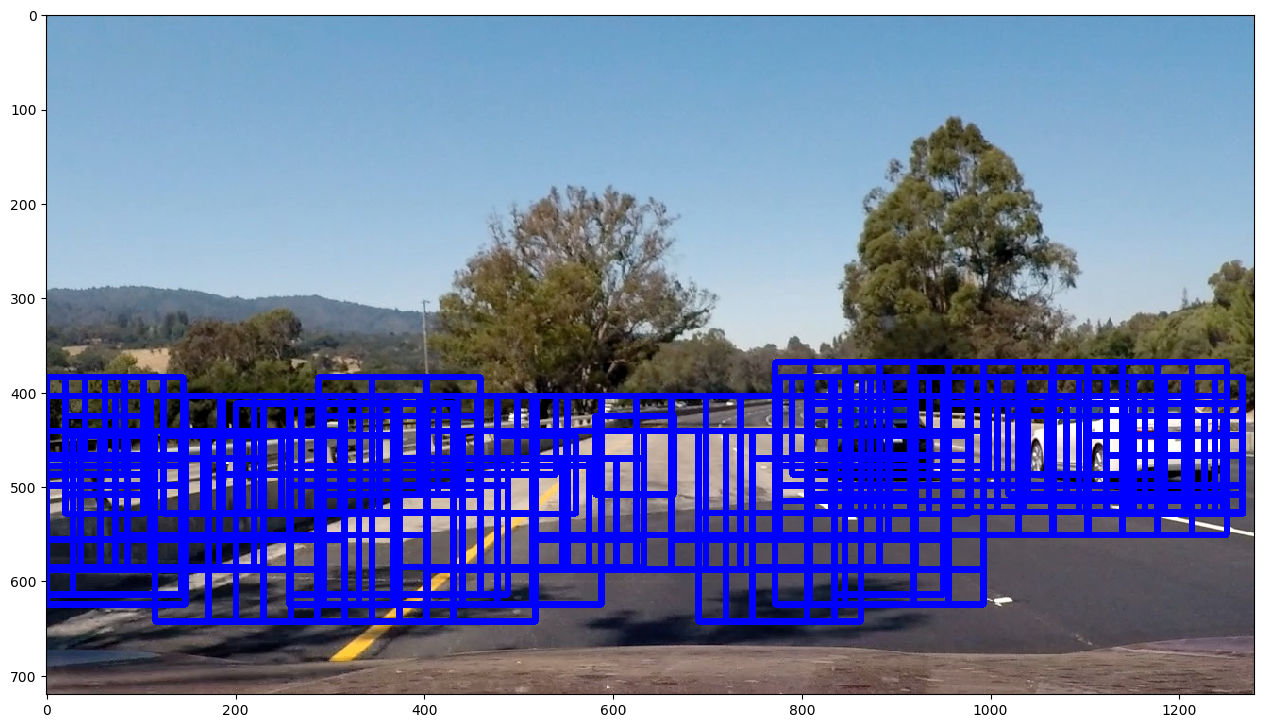

In [15]:
plt.figure(figsize=(16,9), dpi=100)
plt.imshow(draw_boxes(test_img, detected_boxes))

In [16]:
from vehicle_detector import generate_heatmap, apply_threshold
heatmap = generate_heatmap(test_img, detected_boxes)
heatmap = apply_threshold(heatmap, 15)

In [17]:
from scipy.ndimage.measurements import label
labels = label(heatmap)

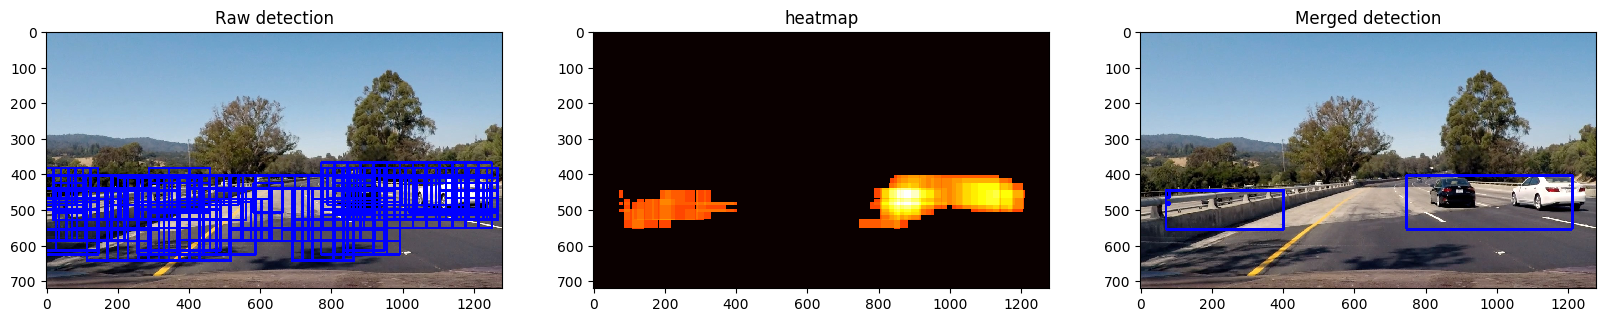

In [18]:
from draw_utils import draw_labeled_bboxes
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

plt.figure(figsize=(20, 20),dpi=100)
plt.subplot(131)
plt.title('Raw detection')
plt.imshow(draw_boxes(test_img, detected_boxes))

plt.subplot(132)
plt.title('heatmap')
plt.imshow(heatmap, cmap='hot')

plt.subplot(133)
plt.title('Merged detection')
plt.imshow(draw_img)

# Detect vehicles in video

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

In [20]:
class BoxesManager:
    
    def __init__(self, n=10):
        self.n = n # length of deque
        self.recent_boxes = deque([], maxlen=n) # hot windows of the last n image
        self.current_boxes = None
        self.allboxes = []
        
    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
    
    def pop_data(self):
        if self.n_buffered > 0:
            self.recent_boxes.pop()
            
    def set_current_boxes(self, boxes):
        self.current_boxes = boxes
    
    def get_all_boxes(self):
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
            
        if len(allboxes) == 0:
            self.allboxes = None
        else:
            self.allboxes = allboxes
    
    def update(self, boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()
        

In [21]:
# Draw debug board with Binarization-View, Lane-Detesction-View
def draw_debug_board(img, bboxes, hot_windows, heatmap, labels):
    
    # prepare RGB heatmap image from float32 heatmap channel
    img_heatmap = (np.copy(heatmap) / np.max(heatmap) * 255.).astype(np.uint8);
    img_heatmap = cv2.applyColorMap(img_heatmap, colormap=cv2.COLORMAP_HOT)
    img_heatmap = cv2.cvtColor(img_heatmap, cv2.COLOR_BGR2RGB)

    # prepare RGB labels image from float32 labels channel
    img_labels = (np.copy(labels) / np.max(labels) * 255.).astype(np.uint8);
    img_labels = cv2.applyColorMap(img_labels, colormap=cv2.COLORMAP_HOT)
    img_labels = cv2.cvtColor(img_labels, cv2.COLOR_BGR2RGB)
    
    # draw hot_windows in the frame
    img_hot_windows = np.copy(img)
    img_hot_windows = draw_boxes(img_hot_windows, hot_windows, thick=2)
    
    ymax = 0
    
    board_x = 5
    board_y = 5
    board_ratio = (img.shape[0] - 3*board_x)//3 / img.shape[0] #0.25
    board_h = int(img.shape[0] * board_ratio)
    board_w = int(img.shape[1] * board_ratio)
        
    ymin = board_y
    ymax = board_h + board_y
    xmin = board_x
    xmax = board_x + board_w

    offset_x = board_x + board_w

    # draw hot_windows in the frame
    img_hot_windows = cv2.resize(img_hot_windows, dsize=(board_w, board_h), interpolation=cv2.INTER_LINEAR)
    img[ymin:ymax, xmin:xmax, :] = img_hot_windows
    
    # draw heatmap in the frame
    xmin += offset_x
    xmax += offset_x
    img_heatmap = cv2.resize(img_heatmap, dsize=(board_w, board_h), interpolation=cv2.INTER_LINEAR)
    img[ymin:ymax, xmin:xmax, :] = img_heatmap
    
    # draw heatmap in the frame
    xmin += offset_x
    xmax += offset_x
    img_labels = cv2.resize(img_labels, dsize=(board_w, board_h), interpolation=cv2.INTER_LINEAR)
    img[ymin:ymax, xmin:xmax, :] = img_labels
    
    return img;

## Pipeline

In [22]:
boxesManager = BoxesManager(n=30)

In [23]:
def process_image(image):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    detected_windows = search_all_scales(image)
    boxesManager.update(detected_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = generate_heatmap(heatmap, boxesManager.allboxes)
    heatmap = apply_threshold(heatmap, 15) # hard-coded value
    labels = label(heatmap)
    window_image = draw_labeled_bboxes(draw_image, labels)
    window_image = draw_debug_board(window_image, boxesManager.allboxes, detected_windows, heatmap, labels[0])
    cv2.putText(window_image, 'Heatmap', (550, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(window_image, 'Label', (1000, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(window_image, 'Raw Detection', (150, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(window_image, 'Merge Detection', (550, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2, cv2.LINE_AA)
    return window_image

In [24]:
inpfile='project_video.mp4'
outfile='project_video_out_debug_2.mp4'
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video project_video_out_debug_2.mp4
[MoviePy] Writing video project_video_out_debug_2.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:34<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_debug_2.mp4 

Wall time: 14min 34s


## Debug view